In [1]:
import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')

import gw150814_simulator as gs
from gw150814_simulator import GW150814, defaults, GW150814_Additive
# import module

import torch
import numpy as np
import scipy
import scipy.stats
import pytorch_lightning as pl
from collections import defaultdict
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

mycolors = ['#77aca2', '#ff004f', '#f98e08']
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')


In [2]:
default = gs.defaults
default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
default['f_max']=250
gw = gs.GW150814(settings=default)
l = len(gw.generate_time_domain_waveform())
s = 1000
tdw = np.zeros([s,l])
tdn = np.zeros([s,l])

for i in tqdm(range(s)):
    tdw[i] = gw.generate_time_domain_waveform()
    tdn[i] = gw.generate_time_domain_noise()

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 307.81it/s]


In [5]:
correlation_scales = torch.tensor([5]).int()
gw150814_post = torch.tensor(tdw)
gw150814_noise = torch.tensor(tdn)
gw150814_samples = {'mu': gw150814_post, 'noise': gw150814_noise}
# simulator = GW150814_Additive(
#     gw150814_samples=gw150814_samples, 
#     bounds=torch.tensor([1.05]), #1.2341, 0.5696, 0.3403]), 
#     dtype=torch.float32,
#     correlation_scales = correlation_scales
# ) ### For correlated version
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=2, 
    dtype=torch.float32,
    fraction = 0.5
) ### For uncorrelated version
# times = simulator._process(simulator.times)
times = simulator.times
Nbins = simulator.Nbins

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 3023.74it/s]


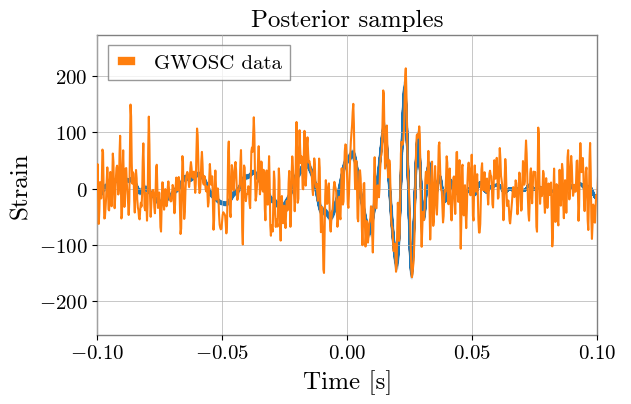

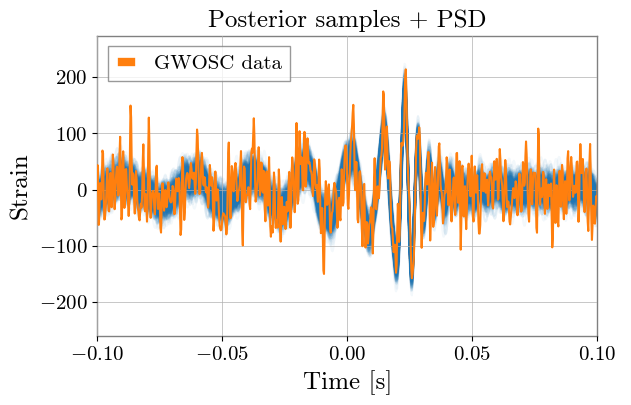

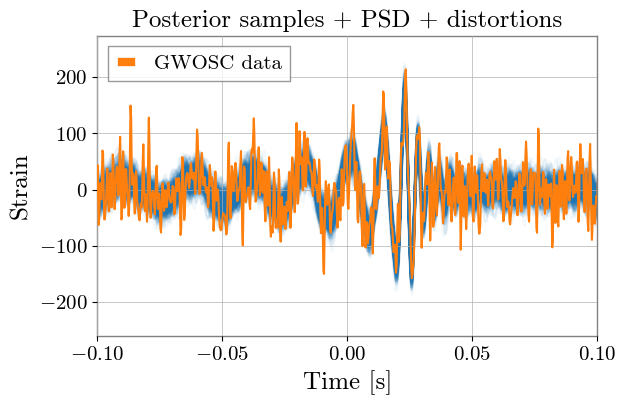

In [6]:
samples = simulator.sample(500)

keys = ['mu','x0','xi',]
titles = ["Posterior samples","Posterior samples + PSD","Posterior samples + PSD + distortions"]
for j in range(3):
    fig,ax = pf.create_plot(size=(5,3))
    ax.set_title(titles[j])
    for i in tqdm(range(500)):
        # global x
        # x = times
        # global y
        # y = samples[keys[j]][i].reshape(-1)
        ax.plot(times, samples[keys[j]][i].reshape(-1), color="C0", alpha=0.05)
    ax.plot(simulator.times, simulator.filter_gwosc_data().reshape(-1), color="C1", zorder=10, label="GWOSC data")
    ax.set_xlim(-0.1, 0.1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Strain")
    ax.legend();


In [7]:
##### FOR UNCORRELATED ADDITIONS #####
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet


class Network_SNR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=True) 
        self.net = ResidualNet(1, 1, 128)
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
                
    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni

        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                                    # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [8]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v for k, v in sample.items()}
    return sample

batch_size = 128
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_SNR = Network_SNR()
model = CustomLossModule_withBounds(network_SNR, learning_rate=8e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=15, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_SNR.cuda().eval();

[phobos:58716] shmem: mmap: an error occurred while determining whether or not /var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T//ompi.phobos.501/jf.0/2436759552/sm_segment.phobos.501.913e0000.0 could be created.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found

Training: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined